In [5]:
# !pip install matplotlib
!pip install scikit-learn
!pip install nltk

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------  8.7/8.7 MB 53.8 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 32.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ------------ --------------------------- 12.3/38.6 MB 59.4 MB/s eta 0:00:01
   ---------------------- ----------------- 22.0/38.6 MB 58.0 MB/s eta 0:00:01
   ----------------------- ---------------- 22.5/38.6 MB 37.5 MB/s eta 0:00:01
   ---------------------------------- ----- 33.6/38.6 MB 39.4 MB/s eta 0:00:01
   ---------------------------------------  38.5/38.6 MB 41.5 MB/s eta 0:00:01
   ---------------------------------------  38.5/38.6 MB 41.5 MB/s eta 0:00:01
   ---------------------------------------- 38.6/38.6 MB 27.8 MB/s eta 0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import math

# NLTK 리소스 다운로드 (최초 1회 실행)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# 한글 폰트 설정 (Mac OS, Windows 사용자 맞게 설정)
import platform
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')

plt.style.use('seaborn-v0_8-whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


총 1792개의 문서를 불러왔습니다.
주제: ['rec.sport.hockey', 'sci.space', 'soc.religion.christian']

첫 번째 문서 전처리 결과 예시: ['idea', 'old', 'space', 'craft', 'navigation', 'beacon', 'put', 'safe', 'pause', 'mode']...
필터링 후 고유한 색인어(차원)의 수: 4582개
생성된 TF-IDF 행렬 크기: (1792, 4582)

메인 센트로이드 벡터 크기: (4582,)
초기 문서 공간의 밀도 Q: 252.5607

용어 판별 가치(DV) 계산 중... (상위/하위 N개 용어만 예시로 계산)

--- 상위 판별 가치 용어 (Good Discriminators) ---
'aint': DV = 0.0252, DF = 5, IDF = 6.88
'yep': DV = 0.0222, DF = 5, IDF = 6.88
'wrap': DV = 0.0183, DF = 5, IDF = 6.88
'worden': DV = 0.0180, DF = 5, IDF = 6.88
'wycliffe': DV = 0.0172, DF = 5, IDF = 6.88
'amen': DV = 0.0140, DF = 5, IDF = 6.88
'attraction': DV = 0.0139, DF = 5, IDF = 6.88
'yake': DV = 0.0115, DF = 5, IDF = 6.88
'annoying': DV = 0.0111, DF = 5, IDF = 6.88
'affiliate': DV = 0.0103, DF = 5, IDF = 6.88

--- 하위 판별 가치 용어 (Poor Discriminators) ---
'year': DV = -1.2483, DF = 335, IDF = 2.68
'team': DV = -1.3007, DF = 248, IDF = 2.98
'people': DV = -1.3248, DF = 359, IDF = 2.61
'know': DV =

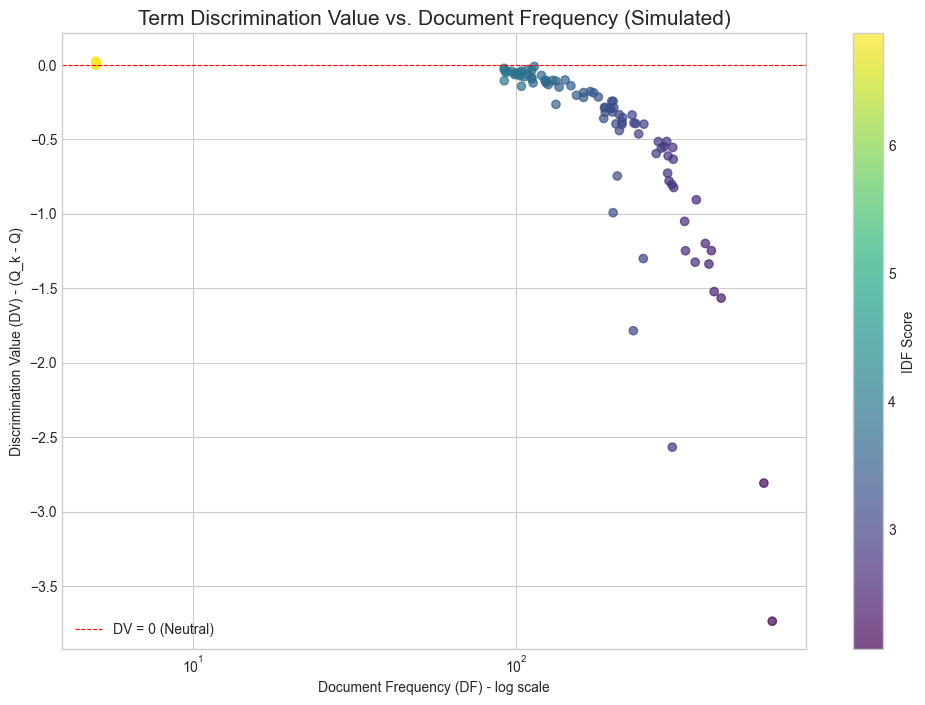


Good Discriminators (가장 높은 DV): ['aint', 'yep', 'wrap', 'worden', 'wycliffe']
Poor Discriminators (가장 낮은 DV): ['like', 'game', 'god', 'one', 'would']


: 

In [ ]:


# --- 1. 데이터 준비 ---
categories = ['sci.space', 'soc.religion.christian', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
documents = newsgroups_train.data
labels = newsgroups_train.target
label_names = newsgroups_train.target_names

print(f"총 {len(documents)}개의 문서를 불러왔습니다.")
print(f"주제: {label_names}")

# --- 2. 전처리 (직접 구현) ---
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

def preprocess_document(doc):
    # 소문자 변환 및 숫자, 구두점 제거
    doc = re.sub(r'[^a-z\s]', '', doc.lower())
    words = doc.split()
    # 불용어 제거 및 어간 추출(표제어 추출)
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in english_stopwords and len(word) > 2]
    return processed_words

processed_documents = [preprocess_document(doc) for doc in documents]
print(f"\n첫 번째 문서 전처리 결과 예시: {processed_documents[0][:10]}...")

# --- 3. TF-IDF 계산 (직접 구현) ---

# 3-1. 모든 고유한 용어(vocabulary) 추출 및 DF(Document Frequency) 계산
vocabulary = defaultdict(int) # 용어: 문서 수
term_in_doc_counts = defaultdict(int) # 용어: 총 등장 횟수
doc_term_counts = [] # 각 문서별 용어 빈도 {term: count}

for doc_words in processed_documents:
    doc_word_freq = defaultdict(int)
    unique_terms_in_doc = set()
    for word in doc_words:
        doc_word_freq[word] += 1
        unique_terms_in_doc.add(word) # 해당 문서에 등장한 고유 용어
        term_in_doc_counts[word] += 1
    
    for word in unique_terms_in_doc:
        vocabulary[word] += 1 # 이 용어가 등장한 문서의 수 (DF)
    doc_term_counts.append(doc_word_freq)

# DF 기준으로 필터링 (최소 5개 문서, 최대 70% 문서에 등장하는 용어만 남김)
min_df = 5
max_df_ratio = 0.7
num_documents = len(documents)
filtered_vocab = {term: df_count for term, df_count in vocabulary.items() 
                  if df_count >= min_df and df_count <= num_documents * max_df_ratio}

# 최종 고유 용어 리스트와 인덱스 매핑
final_terms = sorted(list(filtered_vocab.keys()))
term_to_idx = {term: idx for idx, term in enumerate(final_terms)}
num_features = len(final_terms)
print(f"필터링 후 고유한 색인어(차원)의 수: {num_features}개")

# 3-2. IDF (Inverse Document Frequency) 계산
idf_scores = np.zeros(num_features)
for term, idx in term_to_idx.items():
    df_t = filtered_vocab[term] # 이 용어가 등장한 문서의 수
    # log(N/df_t) + 1 (Scikit-learn의 기본 IDF 공식)
    idf_scores[idx] = math.log(num_documents / df_t) + 1

# 3-3. TF-IDF 행렬 생성
tfidf_matrix = np.zeros((num_documents, num_features))

for i, doc_word_freq in enumerate(doc_term_counts):
    for term, count in doc_word_freq.items():
        if term in term_to_idx: # 필터링된 용어만 처리
            term_idx = term_to_idx[term]
            tf = count # Term Frequency (단순 빈도)
            tfidf_matrix[i, term_idx] = tf * idf_scores[term_idx]

print(f"생성된 TF-IDF 행렬 크기: {tfidf_matrix.shape}")


# --- 4. 문서 간 유사도 및 공간 밀도 측정 (직접 구현) ---

# 코사인 유사도 함수
def cosine_similarity(vec1, vec2):
    if np.sum(vec1) == 0 or np.sum(vec2) == 0:
        return 0 # 0 벡터는 유사도 0
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# 메인 센트로이드(Main Centroid) 계산
main_centroid = np.mean(tfidf_matrix, axis=0)
print(f"\n메인 센트로이드 벡터 크기: {main_centroid.shape}")

# 공간 밀도 Q 계산 (메인 센트로이드와 각 문서 벡터 간 유사도 합)
Q_initial = 0
for i in range(num_documents):
    Q_initial += cosine_similarity(main_centroid, tfidf_matrix[i, :])

print(f"초기 문서 공간의 밀도 Q: {Q_initial:.4f}")


# --- 5. 용어 판별 가치 시뮬레이션 및 시각화 ---

# 용어 판별 가치 계산 (DV_k = Q_k - Q)
# (Q_k: 용어 k를 제거했을 때의 공간 밀도)
discrimination_values = {}
print("\n용어 판별 가치(DV) 계산 중... (상위/하위 N개 용어만 예시로 계산)")

# 모든 용어에 대해 계산하는 것은 매우 오래 걸리므로, 특정 용어들만 선택하여 계산
# 예시: 상위/하위 IDF 용어들, 중간 IDF 용어들
num_sample_terms = 50 

# IDF 점수가 낮은 용어 (흔한 용어) -> 나쁜 판별자 예상
low_idf_term_indices = np.argsort(idf_scores)[:num_sample_terms]
# IDF 점수가 높은 용어 (희귀한 용어) -> 나쁜 판별자 예상 (너무 희귀해서)
high_idf_term_indices = np.argsort(idf_scores)[-num_sample_terms:]
# 중간 IDF 점수 용어 (중간 빈도 용어) -> 좋은 판별자 예상 (수동 범위 조정 필요)
# 여기서는 DF 중간 범위로 대략 선택
df_values = np.array([filtered_vocab[term] for term in final_terms])
mid_df_range_min = num_documents * 0.05
mid_df_range_max = num_documents * 0.3
mid_df_term_indices = np.where((df_values >= mid_df_range_min) & (df_values <= mid_df_range_max))[0]
mid_df_term_indices = np.random.choice(mid_df_term_indices, min(num_sample_terms, len(mid_df_term_indices)), replace=False)

sample_term_indices = np.unique(np.concatenate([low_idf_term_indices, high_idf_term_indices, mid_df_term_indices]))

for idx in sample_term_indices:
    term_to_remove = final_terms[idx]
    
    # 해당 용어(idx)만 0으로 만든 새로운 TF-IDF 행렬 생성
    temp_tfidf_matrix = np.copy(tfidf_matrix)
    temp_tfidf_matrix[:, idx] = 0 # 해당 용어의 가중치를 0으로 설정

    # 새로운 메인 센트로이드 계산
    temp_main_centroid = np.mean(temp_tfidf_matrix, axis=0)

    # 새로운 공간 밀도 Q_k 계산
    Q_k = 0
    for i in range(num_documents):
        Q_k += cosine_similarity(temp_main_centroid, temp_tfidf_matrix[i, :])
    
    # 판별 가치 DV_k = Q_k - Q
    discrimination_values[term_to_remove] = Q_k - Q_initial

# 판별 가치 정렬
sorted_dv = sorted(discrimination_values.items(), key=lambda item: item[1], reverse=True)

print("\n--- 상위 판별 가치 용어 (Good Discriminators) ---")
for term, dv in sorted_dv[:10]:
    print(f"'{term}': DV = {dv:.4f}, DF = {filtered_vocab[term]}, IDF = {idf_scores[term_to_idx[term]]:.2f}")

print("\n--- 하위 판별 가치 용어 (Poor Discriminators) ---")
for term, dv in sorted_dv[-10:]:
    print(f"'{term}': DV = {dv:.4f}, DF = {filtered_vocab[term]}, IDF = {idf_scores[term_to_idx[term]]:.2f}")

# 판별 가치와 문서 빈도(DF) 시각화
dv_terms = list(discrimination_values.keys())
dv_scores = np.array(list(discrimination_values.values()))
df_for_dv_terms = np.array([filtered_vocab[term] for term in dv_terms])
idf_for_dv_terms = np.array([idf_scores[term_to_idx[term]] for term in dv_terms])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_for_dv_terms, dv_scores, c=idf_for_dv_terms, cmap='viridis', alpha=0.7)
plt.title('Term Discrimination Value vs. Document Frequency (Simulated)', fontsize=15)
plt.xlabel('Document Frequency (DF) - log scale')
plt.ylabel('Discrimination Value (DV) - (Q_k - Q)')
plt.xscale('log')
plt.colorbar(scatter, label='IDF Score')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='DV = 0 (Neutral)')
plt.legend()
plt.grid(True)
plt.show()

# 가장 좋은 판별자(Good Discriminator) 5개 예시
good_discriminators = [term for term, dv in sorted_dv[:5]]
print(f"\nGood Discriminators (가장 높은 DV): {good_discriminators}")

# 가장 나쁜 판별자(Poor Discriminator) 5개 예시
poor_discriminators = [term for term, dv in sorted_dv[-5:]]
print(f"Poor Discriminators (가장 낮은 DV): {poor_discriminators}")